<a href="https://colab.research.google.com/github/Jieoi/traffic_sign/blob/main/traffic_sign_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> 2.1 Data Preparation for Machine Learning</h1>

<h2>2.1.1 Preparing the notebook</h2>

The first step is to connect to Google Drive so that the data enhanced in the previouse notebook can be used.

The exact files that the notebook needs to  access are <code>final_image.zip</code> and <code>image_data.csv</code>. It can be found in the link <a href="https://drive.google.com/drive/folders/1nViTcpc952b0ftRGqkDBFqbSEC01t0a8">here</a>.

Ideally, the notebook should be run in Google Colab with high RAM and GPU support. However, the code can be excuted on CPU only mode with a longer training time.

In [1]:
# Checking GPU availability
!nvidia-smi

Fri Sep  1 08:24:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


The libraries used in this notebook are listed below.

In [24]:
# Zip file handling
import zipfile
import os

# Data handling and visualization
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# File handling and management for training and validation data
from shutil import copyfile
from sklearn.model_selection import train_test_split

#
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import regularizers

from tensorflow.keras.models import save_model

<h2>2.1.2 Data preparation for Machine Learning</h2>

The labels for all the images is in the <code>image_data.csv</code> file. It is first extracted in the code below.

In [4]:
csv_file = '/content/drive/MyDrive/final/image_data.csv'

# Read the CSV file into a pandas DataFrame
df_classes = pd.read_csv(csv_file)
df_classes.info

<bound method DataFrame.info of        class      filename
0         32      32_0.png
1         32      32_1.png
2         32      32_2.png
3         32      32_3.png
4         32      32_4.png
...      ...           ...
35435     42  42_35435.png
35436     42  42_35436.png
35437     42  42_35437.png
35438     42  42_35438.png
35439     42  42_35439.png

[35440 rows x 2 columns]>

Then the images are extracted from the <code>final_image.zip</code> file.

In [5]:
# Paths
zip_file_path = '/content/drive/MyDrive/final/final_image.zip'
extracted_dir = '/content/extracted_images'

# Create the directory for extracted images if it doesn't exist
os.makedirs(extracted_dir, exist_ok=True)


# Open the ZIP file and extract its contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

# Check the length of the extracted images
num_extracted_images = len(os.listdir(extracted_dir))
print(f"Number of extracted images: {num_extracted_images}")
print("Extraction completed.")

Number of extracted images: 35440
Extraction completed.


Both images and there labels extracted contains the same number of entries.

The distribution of the final classes is shown below.

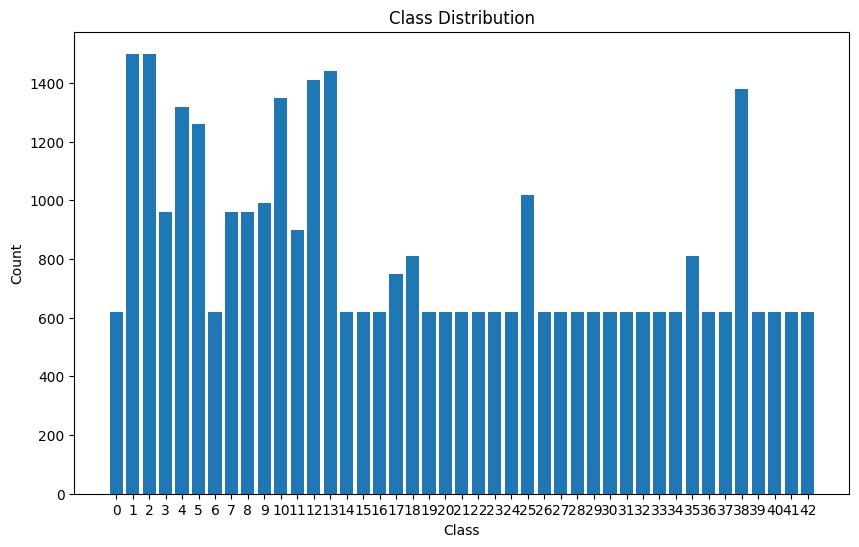

In [6]:
# Count the occurrences of each class in the DataFrame
class_counts = df_classes['class'].value_counts()

# Sort the unique class IDs
unique_classes = np.sort(df_classes['class'].unique())

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(unique_classes, class_counts[unique_classes])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(unique_classes)
plt.show()

Both images are first split into training and validation sets. They are grouped by their classes and stored in individual directories for every classes.

In [7]:
train_dir = '/content/train_images'
valid_dir = '/content/valid_images'

# Create directories for training and validation images
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)

# Split the data into training and validation sets
train_df, valid_df = train_test_split(df_classes, test_size=0.2, random_state=42, stratify=df_classes['class'])

# Copy images to directories based on classes for training set
for index, row in train_df.iterrows():
    src_path = os.path.join(extracted_dir, row['filename'])
    dst_path = os.path.join(train_dir, str(row['class']), row['filename'])
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    copyfile(src_path, dst_path)

# Copy images to directories based on classes for validation set
for index, row in valid_df.iterrows():
    src_path = os.path.join(extracted_dir, row['filename'])
    dst_path = os.path.join(valid_dir, str(row['class']), row['filename'])
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    copyfile(src_path, dst_path)

print("Data preparation for ML completed.")

Data preparation for ML completed.


<h1> 2.2 Machine Learning</h1>

<h2>2.2.1 Data pipeline</h2>

<code>flow_from_directory()</code> from Keras ImageDataGenerator is used to load the images with rescaling to 1/255. batch size and image size are pre-set to 32 and (128, 128), respectively.

In [8]:
# Define paths
train_dir = '/content/train_images'
valid_dir = '/content/valid_images'

# Define image dimensions and batch size
image_size = (128, 128)
batch_size = 32

# Create data generators and rescale image for ML on training and validation
train_datagen = ImageDataGenerator(rescale=1.0/255,)
valid_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Get the number of classes from the training generator
num_classes = len(train_generator.class_indices)

Found 28352 images belonging to 43 classes.
Found 7088 images belonging to 43 classes.


<h2>2.2.2 Training the CNN model</h2>

Double checking the GPU availability and set the GPU device if it is available

In [9]:
# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Specify GPU device
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


A function is defined to plot the training history

In [10]:
def calculate_accuracy_increase_rate(history):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    train_rate = np.mean(np.diff(train_accuracy))
    val_rate = np.mean(np.diff(val_accuracy))

    return train_rate, val_rate

In [11]:
def plot_training_history(history):
    # Access the training history
    training_loss = history.history['loss']
    training_accuracy = history.history['accuracy']
    validation_loss = history.history['val_loss']
    validation_accuracy = history.history['val_accuracy']

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plotting the training and validation accuracy
    ax1.plot(training_accuracy)
    ax1.plot(validation_accuracy)
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Plotting the training and validation loss
    ax2.plot(training_loss)
    ax2.plot(validation_loss)
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Train', 'Validation'], loc='upper right')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the figure
    plt.show()

Training the CNN model to upto 30 epochs, early stopping is used to prevent overfitting. However, no regularization is applied.

In [12]:
# Define the CNN model
with tf.device('/device:GPU:0'):
  model = Sequential([
      Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
      MaxPooling2D(2, 2),

      Conv2D(64, (3, 3), activation='relu'),
      MaxPooling2D(2, 2),

      Conv2D(128, (3, 3), activation='relu'),
      MaxPooling2D(2, 2),

      Flatten(),
      Dense(512, activation='relu'),
      Dropout(0.5),
      Dense(num_classes, activation='softmax')  # Make sure to set num_classes to the number of classes
  ])

  # Compile the model
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # Early stopping callback
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

  # Train the model
  num_epochs = 30
  history_simpleCNN=model.fit(train_generator, epochs=num_epochs, validation_data=valid_generator,callbacks=[early_stopping])

print("Model training completed.")

Epoch 1/30
886/886 [==============================] - 49s 41ms/step - loss: 1.3865 - accuracy: 0.5955 - val_loss: 0.4625 - val_accuracy: 0.8574
Epoch 2/30
886/886 [==============================] - 35s 39ms/step - loss: 0.5004 - accuracy: 0.8399 - val_loss: 0.2634 - val_accuracy: 0.9168
Epoch 3/30
886/886 [==============================] - 35s 40ms/step - loss: 0.3153 - accuracy: 0.8987 - val_loss: 0.2053 - val_accuracy: 0.9368
Epoch 4/30
886/886 [==============================] - 34s 39ms/step - loss: 0.2342 - accuracy: 0.9248 - val_loss: 0.1651 - val_accuracy: 0.9499
Epoch 5/30
886/886 [==============================] - 34s 39ms/step - loss: 0.1812 - accuracy: 0.9404 - val_loss: 0.1846 - val_accuracy: 0.9410
Epoch 6/30
886/886 [==============================] - 35s 39ms/step - loss: 0.1478 - accuracy: 0.9523 - val_loss: 0.1637 - val_accuracy: 0.9488
Epoch 7/30
886/886 [==============================] - 35s 39ms/step - loss: 0.1269 - accuracy: 0.9584 - val_loss: 0.1447 - val_accuracy:

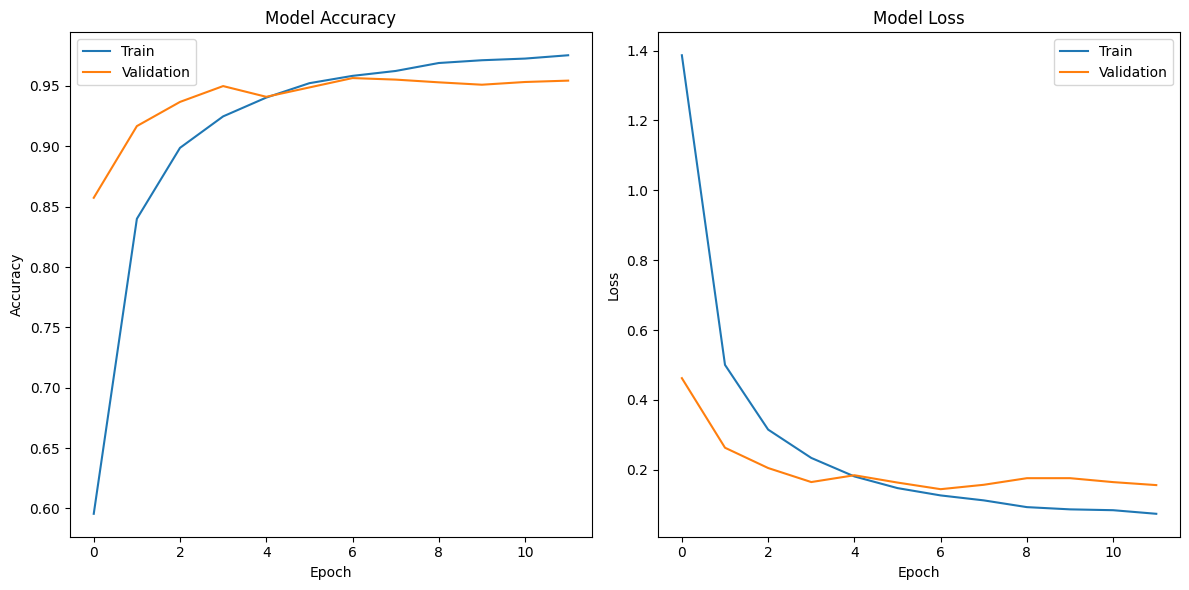

In [13]:
plot_training_history(history_simpleCNN)

In [14]:
# Increasing rate
train_rate1, val_rate1 = calculate_accuracy_increase_rate(history_simpleCNN)
print("Training Accuracy Increase Rate:", train_rate1)
print("Validation Accuracy Increase Rate:", val_rate1)

Training Accuracy Increase Rate: 0.03453981334512884
Validation Accuracy Increase Rate: 0.008824137124148283


More complexity is added to the CNN model with regularization added:

Added more convolutional layers with increasing filters to capture more complex features.
Added batch normalization layers after each convolutional and dense layer to help stabilize training.
Added an additional dense layer with dropout and batch normalization.

In [15]:
# Define the CNN model with more complexity and regularization
with tf.device('/device:GPU:0'):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D(2, 2),
        BatchNormalization(),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),
        Dropout(0.25),

        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),
        Dropout(0.25),

        Flatten(),

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    num_epochs = 30
    history_normCNN = model.fit(train_generator, epochs=num_epochs, validation_data=valid_generator, callbacks=[early_stopping])

print("Model training completed.")

Epoch 1/30
886/886 [==============================] - 62s 64ms/step - loss: 1.2040 - accuracy: 0.6499 - val_loss: 0.6317 - val_accuracy: 0.8063
Epoch 2/30
886/886 [==============================] - 56s 63ms/step - loss: 0.4368 - accuracy: 0.8641 - val_loss: 0.3451 - val_accuracy: 0.8897
Epoch 3/30
886/886 [==============================] - 56s 63ms/step - loss: 0.2702 - accuracy: 0.9170 - val_loss: 0.8385 - val_accuracy: 0.7634
Epoch 4/30
886/886 [==============================] - 56s 64ms/step - loss: 0.1748 - accuracy: 0.9436 - val_loss: 0.2934 - val_accuracy: 0.9076
Epoch 5/30
886/886 [==============================] - 56s 63ms/step - loss: 0.1249 - accuracy: 0.9591 - val_loss: 0.1994 - val_accuracy: 0.9389
Epoch 6/30
886/886 [==============================] - 56s 63ms/step - loss: 0.1058 - accuracy: 0.9647 - val_loss: 0.3448 - val_accuracy: 0.9007
Epoch 7/30
886/886 [==============================] - 55s 63ms/step - loss: 0.0923 - accuracy: 0.9698 - val_loss: 0.2377 - val_accuracy:

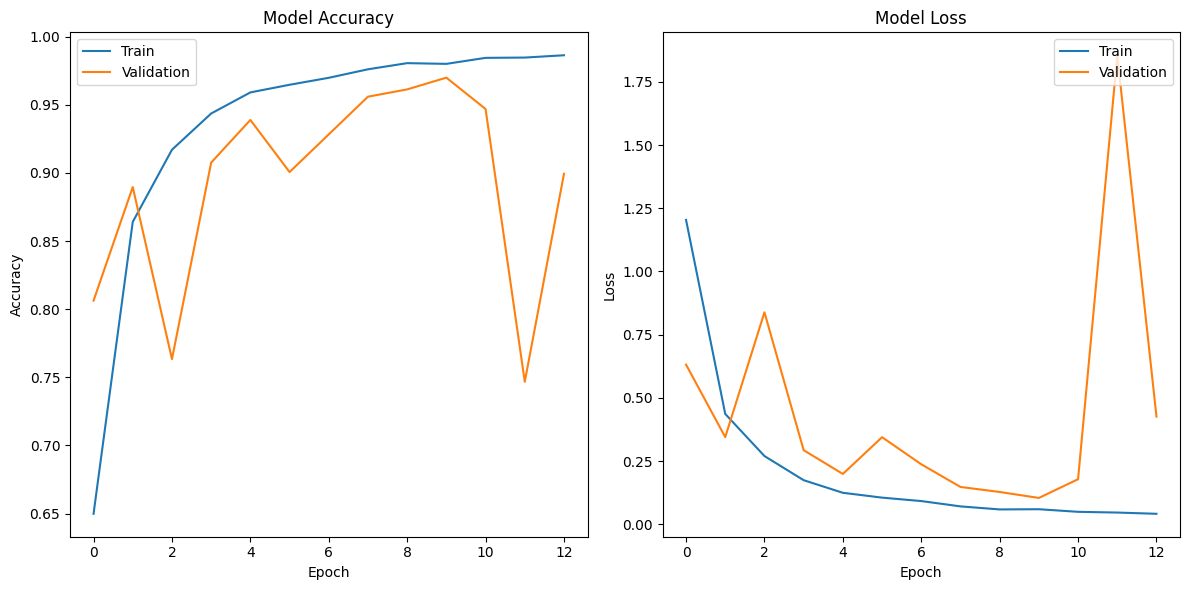

In [16]:
plot_training_history(history_normCNN)

In [17]:
# Increasing rate
train_rate2, val_rate2 = calculate_accuracy_increase_rate(history_normCNN)
print("Training Accuracy Increase Rate:", train_rate2)
print("Validation Accuracy Increase Rate:", val_rate2)

Training Accuracy Increase Rate: 0.02804328997929891
Validation Accuracy Increase Rate: 0.00775959591070811


In [18]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

def step_decay(epoch, initial_lr):
    drop_rate = 0.2
    epochs_drop = 15
    new_lr = initial_lr * (drop_rate ** (epoch // epochs_drop))
    return new_lr

initial_lr = 0.001

with tf.device('/device:GPU:0'):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D(2, 2),
        BatchNormalization(),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),
        Dropout(0.25),

        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),
        Dropout(0.25),

        Flatten(),

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(num_classes, activation='softmax')
    ])

    # Compile the model with initial learning rate
    optimizer = Adam(learning_rate=initial_lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Define the step decay schedule
    lr_schedule = LearningRateScheduler(lambda epoch: step_decay(epoch, initial_lr))

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model with step decay learning rate
    num_epochs = 30
    history_normCNNlr = model.fit(train_generator, epochs=num_epochs, validation_data=valid_generator, callbacks=[lr_schedule, early_stopping])

print("Model training completed.")


Epoch 1/30
886/886 [==============================] - 62s 65ms/step - loss: 1.2213 - accuracy: 0.6475 - val_loss: 0.9941 - val_accuracy: 0.7075 - lr: 0.0010
Epoch 2/30
886/886 [==============================] - 56s 63ms/step - loss: 0.4399 - accuracy: 0.8637 - val_loss: 0.2637 - val_accuracy: 0.9137 - lr: 0.0010
Epoch 3/30
886/886 [==============================] - 56s 63ms/step - loss: 0.2704 - accuracy: 0.9156 - val_loss: 0.3886 - val_accuracy: 0.8798 - lr: 0.0010
Epoch 4/30
886/886 [==============================] - 56s 63ms/step - loss: 0.1735 - accuracy: 0.9449 - val_loss: 0.3401 - val_accuracy: 0.8945 - lr: 0.0010
Epoch 5/30
886/886 [==============================] - 56s 63ms/step - loss: 0.1363 - accuracy: 0.9567 - val_loss: 0.2101 - val_accuracy: 0.9312 - lr: 0.0010
Epoch 6/30
886/886 [==============================] - 56s 63ms/step - loss: 0.0943 - accuracy: 0.9699 - val_loss: 0.1870 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 7/30
886/886 [==============================] - 56s 

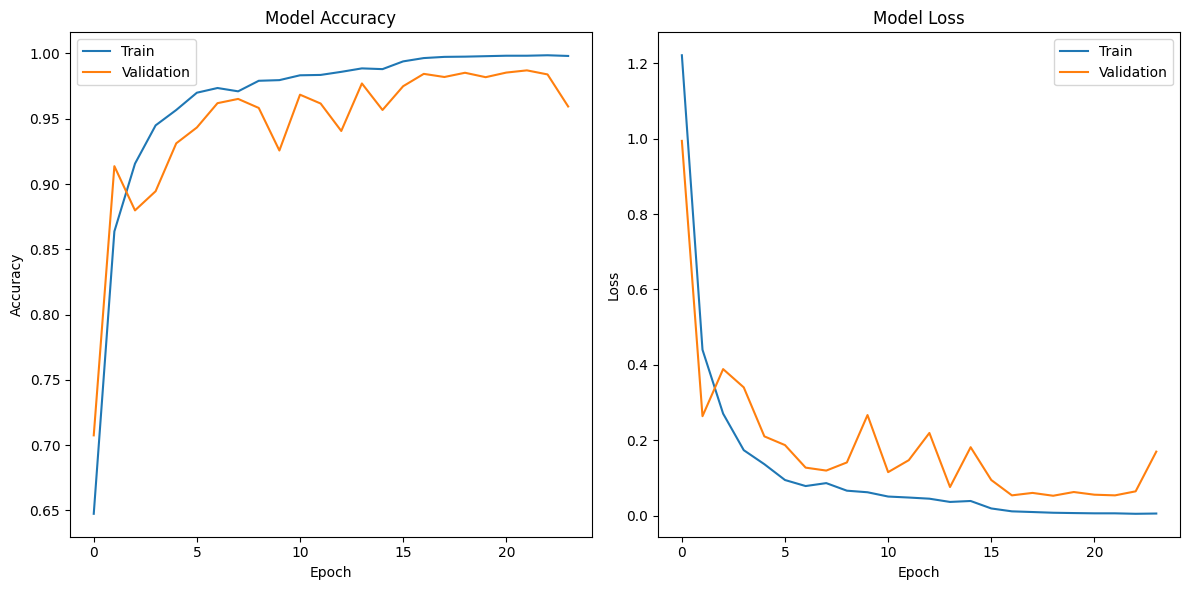

In [21]:
plot_training_history(history_normCNNlr)

In [22]:
train_rate3, val_rate3 = calculate_accuracy_increase_rate(history_normCNNlr)
print("Training Accuracy Increase Rate:", train_rate3)
print("Validation Accuracy Increase Rate:", val_rate3)

Training Accuracy Increase Rate: 0.015243154505024786
Validation Accuracy Increase Rate: 0.010949308457581894


<h1> 2.3 Saving the model</h1>

In [29]:
model.save("final_CNN_model.h5")

In [30]:
def save_training_history(history, filename):
    # Create a DataFrame from the training history
    history_df = pd.DataFrame(history.history)

    # Save the DataFrame to a CSV file
    history_df.to_csv(filename, index=False)

    # Print the first few rows of the history DataFrame
    print(history_df.head())

In [31]:
save_training_history(history_simpleCNN, 'training_history_simpleCNN.csv')

       loss  accuracy  val_loss  val_accuracy
0  1.386500  0.595514  0.462456      0.857365
1  0.500422  0.839941  0.263366      0.916761
2  0.315259  0.898737  0.205290      0.936795
3  0.234200  0.924802  0.165122      0.949915
4  0.181216  0.940392  0.184602      0.941027


In [32]:
save_training_history(history_normCNN, 'training_history_normCNN.csv')

       loss  accuracy  val_loss  val_accuracy
0  1.204031  0.649866  0.631723      0.806292
1  0.436752  0.864101  0.345136      0.889673
2  0.270235  0.917043  0.838497      0.763403
3  0.174781  0.943637  0.293440      0.907590
4  0.124949  0.959121  0.199398      0.938911


In [33]:
save_training_history(history_normCNNlr, 'training_history_normCNNlr.csv')

       loss  accuracy  val_loss  val_accuracy     lr
0  1.221272  0.647468  0.994114      0.707534  0.001
1  0.439928  0.863713  0.263699      0.913657  0.001
2  0.270427  0.915597  0.388583      0.879797  0.001
3  0.173524  0.944907  0.340149      0.894469  0.001
4  0.136273  0.956687  0.210107      0.931151  0.001


In [34]:
import shutil
import os

# Define the destination directory in Google Drive
dest_dir = '/content/drive/MyDrive/final/training_models/CNN/'

# Create the destination directory if it doesn't exist
os.makedirs(dest_dir, exist_ok=True)

# Define the source paths
src_paths = [
    'final_CNN_model.h5',
    'training_history_simpleCNN.csv',
    'training_history_normCNN.csv',
    'training_history_normCNNlr.csv'
]

# Copy files to Google Drive
for src_path in src_paths:
    shutil.copy(src_path, dest_dir)

print("Files copied to Google Drive successfully.")

Files copied to Google Drive successfully.
